In [50]:
#import cudf
import numpy as np
import sys
import os
import argparse
import pickle
import fnmatch
from tqdm import tqdm
import re
import itertools
import random
import argparse
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.cm as cm
from sklearn import manifold
import torch
from utils import train_pool

ROOTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/'
RESULTDIR = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/results'
analyze_dir = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/analyze/'
save_dir = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/extracted/'

#model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.0923671_sigma=5.0_nfeat=936-train_test-fixed'
#model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.0923671_sigma=5.0_nfeat=936-train_test-fixed'
#model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier = 'mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'

## Helper functions ##
def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    nan_loc=np.argwhere(np.isnan(x))
    mov_temp=pd.Series(x).rolling(w, min_periods=w_min).mean()
    mov_temp=np.asarray(mov_temp)
    mov_temp[nan_loc]=np.nan
    return mov_temp



av_window=10
load_d = False

In [51]:
if load_d:
    with open(os.path.join(analyze_dir, f"d_fig2_plot_specs_{model_identifier}.pkl"), "rb") as input_file:
        d = pickle.load(input_file)
        
    d.keys()

In [52]:
# load accuracy data first 
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

hier_accu=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
    del test 
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [00:08, 125.20it/s]


In [53]:
hier_accu=[hier_accu[x] for x in fixed_idx]
accuracies=np.stack([x[2] for x in hier_accu])
batches=np.stack([x[1] for x in hier_accu])
epochs=np.stack([x[0] for x in hier_accu])
epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*epochs+batches


In [54]:
x_bar= np.arange(len(batches))/len(batches)
epoch_bar=np.argwhere(np.diff(epochs))/(len(batches))
epoch_bar

array([[0.0990566],
       [0.1990566],
       [0.2990566],
       [0.3990566],
       [0.4990566],
       [0.5990566],
       [0.6990566],
       [0.7990566],
       [0.8990566]])

In [55]:
# load mftma files 
data_=pickle.load(open(os.path.join(analyze_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_cosine_center_covar_pooled_v3.pkl'), 'rb'))

covar_res=data_['center_covar_results']
#if not os.path.exists(os.path.join(result_dir,analyze_identifier,model_identifier)):
#        os.makedirs(os.path.join(result_dir,analyze_identifier,model_identifier))
temp=[np.asarray([x['seq'] for x in covar_res[y]]) for y in covar_res.keys()]
y=temp[0]
for k in temp:
    y=np.intersect1d(y,k)
l_num=1
mftma_epochs=[np.asarray([x['epoch'] for x in covar_res[y]]) for y in covar_res.keys()]
mftma_batch=[np.asarray([x['batch'] for x in covar_res[y]]) for y in covar_res.keys()]
layer_data=covar_res['layer_1_Linear']
layer_mftma=[x['center_covar'] for x in layer_data]
mftma_epoch_batch=epoch_factor*np.array(mftma_epochs[l_num])+np.array(mftma_batch[l_num])
array_correspondance=[np.argwhere(x==epoch_batch) for x in mftma_epoch_batch]
params = train_pool[model_identifier]()
params.load_dataset()
transfo_mat=params.dataset.transformation_mats

ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "data": shape (128252,), type "|u1">, (uint8)
ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "ir": shape (128252,), type "<u8">, (uint64)
ERROR:root:ERROR: not a MATLAB datatype: <HDF5 dataset "jc": shape (64128,), type "<u8">, (uint64)
ERROR:root:ERROR: MATLAB type not supported: graph, (uint32)
ERROR:root:ERROR: MATLAB type not supported: graph, (uint32)


In [56]:
within_class_id=[np.unique(x,axis=0)+1 for x in params.dataset.hierarchical_target]

In [57]:
within_cell=[];
between_cell=[];
between_2_cell=[];
for idx , _ in enumerate(range(len(within_class_id)-2)):
    within=within_class_id[idx]
    within=np.expand_dims(within,axis=0)
    temp=np.matmul(np.transpose(within),within)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    within_class=temp==temp1;
    within_cell.append(within_class)

    between=np.repeat(np.expand_dims(np.unique(params.dataset.hierarchical_target[idx+1])+1,axis=0),2,axis=1)
    temp=np.matmul(np.transpose(between),between)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    between_class=temp==temp1
    between_cell.append(between_class)
    
    
    between=np.repeat(np.expand_dims(np.unique(params.dataset.hierarchical_target[idx+2])+1,axis=0),4,axis=1)
    temp=np.matmul(np.transpose(between),between)
    temp1=np.repeat(np.expand_dims(np.diag(temp),axis=0),within.shape[1],axis=0)
    between_class=temp==temp1
    between_2_cell.append(between_class)

In [58]:
hier_within_class=[]
hier_between_class=[]
for idx, _ in enumerate(range(len(within_cell))):
    A=within_cell[idx]==(~between_cell[idx])
    hier_within_class.append(A)
    
    B=within_cell[idx]==(~between_2_cell[idx])
    B=B== ~A
    hier_between_class.append(B)


___________ Layer: layer_1_Linear____________
Hierarchy 0: Fixed point collapsed: 466 | Fixed point: 46577


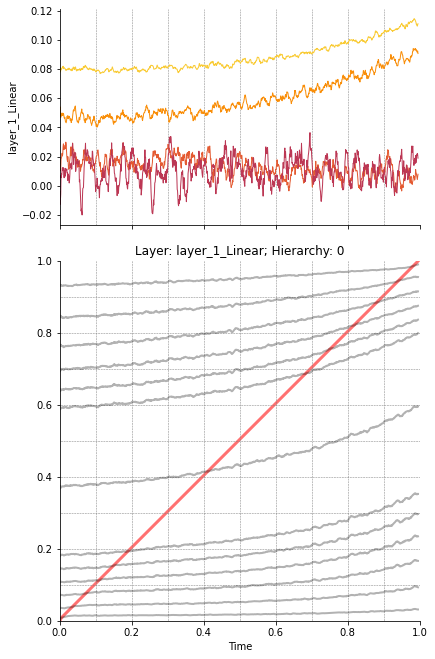

In [59]:
## INCLUDE PLOTS IN THE LOOP ##
## SPECS ALL ##
# layers = ['layer_1_Linear', 'layer_2_Linear', 'layer_3_Linear'] # 'layer_0_Input'
layers = ['layer_1_Linear']
hier_idxs = np.arange(6)
hier_idxs = [0]
num_colors=len(layers)+1
h0=cm.get_cmap('inferno_r',num_colors)
layer_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

num_colors=accuracies.shape[1]+1
color_fact=num_colors+2
h0=cm.get_cmap('inferno',color_fact)
line_cols=np.flipud(h0(np.arange(color_fact)/color_fact))
line_cols=line_cols[1:,:]
v='v3'

xtick=np.arange(0,12,2)/10

num_colors=len(hier_idxs)+1
h0=cm.get_cmap('viridis_r',num_colors)
hier_cols=np.flipud(h0(np.arange(num_colors)/num_colors))

for row, layer in enumerate(layers):
    print(f'\n___________ Layer: {layer}____________')
    for hier_idx in hier_idxs:

        num_subsamples = 100
        k = 100
        # hier_idx = 5
        # layer = layers[0]
        mov_avg = 10 
        save_fig = True
        collapse_subsamples = True # whether to average across num_subsamples! currently both computed
        p_array = [1, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 99]
        #p_array = [0.01,0.1,0.5,1, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 99,99.5,99.9,99.99]
        #p_array = [0.1,1, 5, 10, 15, 20, 25, 50, 75, 80, 85, 90, 95, 99,99.9]
        #p_array = [25,50, 75]

        knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
        pkl_name = f'layer={layer}_hier={hier_idx}_{v}.pkl'

        SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
        PLOTDIR = os.path.join(ROOTDIR, 'results', knn_identifier, model_identifier, train_identifier)

        if not os.path.exists(PLOTDIR):
            os.makedirs(PLOTDIR)

        data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

        D = data['D']
        I = data['I']
        I_stand = I/np.max(I)
        epochs = data['epochs']  

        D_k_mean = np.mean(D,axis=1)
        D_k_mean_collapsed = np.mean(D_k_mean.reshape(-1, num_subsamples),axis=1)

        # analyses of fixed points and percentiles
        # compute percentiles
        p = np.percentile(I_stand, p_array, axis=1)
        p_collapse = [np.mean(x.reshape(-1, num_subsamples),axis=1) for x in p]
        time_diag = np.arange(len(D_k_mean))
        time_diag_collapsed = np.arange(len(D_k_mean_collapsed))/1060#*100

        norms = np.zeros((k-1, I.shape[0]))
        for i in range(1, k):
            norms[i-1, :] = I[:, 0] - I[:, i] 

        mean_norms = np.mean(norms,axis=0)
        mean_k_norms = np.mean(norms,axis=1)
        # norms_mov_avg = (moving_average(abs(mean_norms), mov_avg))

        norms_collapsed = np.mean(mean_norms.reshape(-1, num_subsamples),axis=1)

        # norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg_collapsed = moving_average(abs(norms_collapsed), mov_avg)
        fixed_point = np.argmin((norms_mov_avg))
        fixed_point_collapsed = np.argmin((norms_mov_avg_collapsed))
        print(f'Hierarchy {hier_idx}: Fixed point collapsed: {fixed_point_collapsed} | Fixed point: {fixed_point}')

        ## PLOTS ##
        alpha=0.3
        plt.figure(figsize=(15,10))
        ax=plt.subplot(position=(.1,.1,.5*10/15,.5))
        for i in range(len(p_array)):
            plt.plot(moving_average(x_bar,av_window),moving_average(p_collapse[i], av_window), label=f'Percentile {p_array[i]}', alpha=alpha, color='k',linewidth=2,zorder=5)
#         for h in range(6):
#             plt.plot(np.arange(1060),moving_average([accs[i][h] for i in range(len(accs))],av_window)/100,label=f'hier: {h}')
        if load_d:
            k=1 # layer 1
            layer_data=d['dist'][k]
            for h, hier_data in enumerate(layer_data):
                distance_data=hier_data['data'].mean(axis=1)
                corrected_data=list(np.empty(1060)*np.NaN)
                for idx, x in enumerate(d['arr_']):
                    corrected_data[int(x)]=distance_data[idx]

                plt.plot(moving_average(corrected_data/np.max(corrected_data),av_window),label=f"n_class:{hier_data['data'].shape[1]}")

        plt.xlabel('Time')
        plt.title(f'Layer: {layer}; Hierarchy: {hier_idx}')
        ax.plot(moving_average(x_bar,av_window), time_diag_collapsed,color=(1,.3,.3), label='Current pseudotime',linewidth=3,zorder=0,alpha=.8)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
        ax.hlines(epoch_bar,ax.get_xlim()[0],ax.get_xlim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
        #ax.autoscale(enable=True, axis='x', tight=True)
        #ax.autoscale(enable=True, axis='y', tight=True)
        # 
        # plot layer 1 results
        layer='layer_1_Linear'
        hier_within_between=[]
        for k_idx,_ in enumerate(hier_within_class):
            withins=[]
            betweens=[]
            for X in covar_res[layer]:
                within=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_within_class[k_idx]]
                between=np.asarray(X['center_covar'][k_idx]['center_cov']).squeeze()[hier_between_class[k_idx]]
                withins.append(np.mean(within))
                betweens.append(np.mean(between))
            hier_within_between.append(np.stack([withins,betweens]))
        ax.axes.xaxis.set_ticks(xtick)
        #ax.autoscale(enable=True, axis='x', tight=True)
        #ax.autoscale(enable=True, axis='y', tight=True)

        ax.set_xlim((.0,1.))
        ax.set_ylim((.0,1.))
        
        ax=plt.subplot(position=(.1,.65,.5*10/15,.3))

        for t in range(len(hier_within_between)):
            ax.plot(moving_average(x_bar,av_window),moving_average(hier_within_between[t][1,:]-hier_within_between[t][0,:],av_window),color=line_cols[t,:],linewidth=1,label=f"n class: {hier_within_class[t].shape[0]}")


        ax.set_ylabel(layer)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.vlines(epoch_bar,ax.get_ylim()[0],ax.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
        ax.autoscale(enable=True, axis='x', tight=True)
        ax.autoscale(enable=True, axis='y', tight=True)
        ax.axes.xaxis.set_ticks(xtick)
        ax.axes.xaxis.set_ticklabels([])


        
        
if not os.path.exists(f'{RESULTDIR}/{train_identifier}'):
    os.makedirs(f'{RESULTDIR}/{train_identifier}')

plt.savefig(f'{RESULTDIR}/{train_identifier}/knn_{model_identifier}_{v}.pdf')
# fig1.savefig(f'{RESULTDIR}/{train_identifier}/fig1_{model_identifier}_{v}.pdf')
# fig2.savefig(f'{RESULTDIR}/{train_identifier}/fig2_{model_identifier}_{v}.pdf')

In [60]:
RESULTDIR

'/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/results'

In [14]:
quant=np.stack([moving_average(x_bar,av_window),moving_average(p_collapse[1],av_window)])

(2, 1060)

In [29]:
def polar(z):
    x,y = z[0,:], z[1,:]
    r = np.sqrt(x**2+y**2)
    t = np.arctan2(y,x)
    return np.stack([r,t])

In [31]:
polar(quant).shape

(2, 1060)

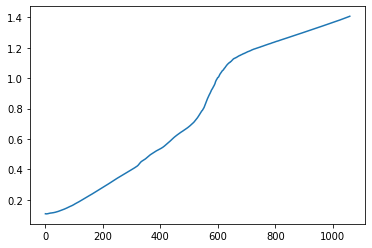

In [32]:
plt.plot(polar(quant)[0])

In [35]:
np.min(polar(quant)[0,:])

0.10727758804972443

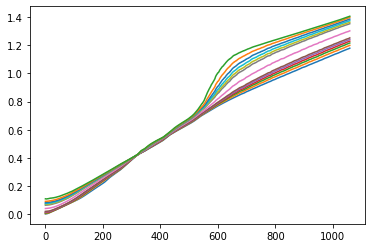

In [26]:
for i in range(len(p_array)):
        quant=np.stack([moving_average(x_bar,av_window),moving_average(p_collapse[i],av_window)])
        plt.plot(polar(quant)[0])



In [30]:
theta=np.pi/4
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s), (s, c)))


array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [35]:
quant_rot=np.matmul(quant.transpose(),R)
quant_rot.shape

(1060, 2)

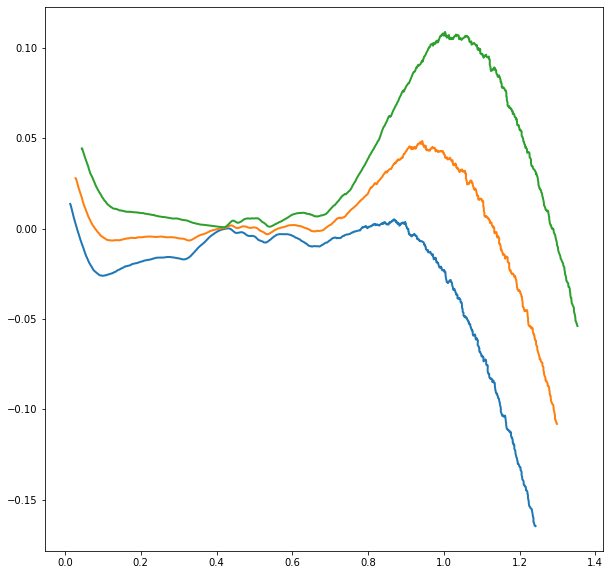

In [44]:
plt.figure(figsize=(10,10))
quant_rot_l=[]
for i in range(len(p_array)):
        quant=np.stack([moving_average(x_bar,av_window),moving_average(p_collapse[i],av_window)])
        quant_rot=np.matmul(quant.transpose(),R)
        quant_rot_l.append(quant_rot)
        plt.plot(quant_rot[:,0],quant_rot[:,1], linewidth=2,zorder=5)


In [54]:
qunat_diff=quant_rot_l[2][:,1]-quant_rot_l[1][:,1]

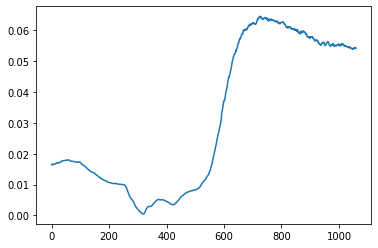

In [59]:
plt.plot(qunat_diff)

In [51]:
qunat_diff

array([[0.01649255, 0.01649255],
       [0.01653401, 0.01653401],
       [0.01640866, 0.01640866],
       ...,
       [0.05437172, 0.05437172],
       [0.05406549, 0.05406549],
       [0.05409781, 0.05409781]])

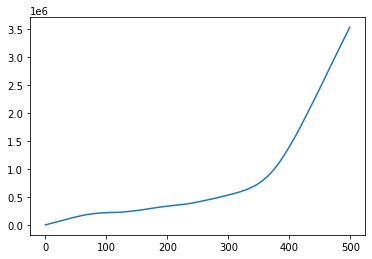

In [91]:
plt.plot(np.cumsum(p_collapse[2][200:700] - p_collapse[1][200:700]))

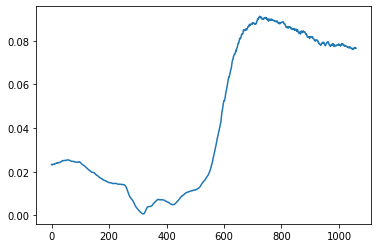

In [58]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window))


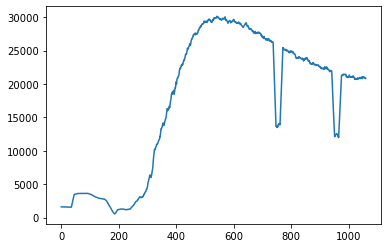

In [100]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window))

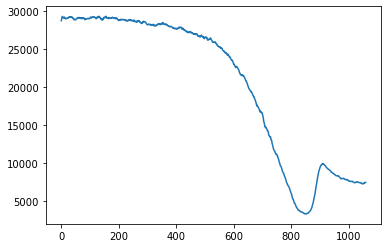

In [103]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window)) # partition line

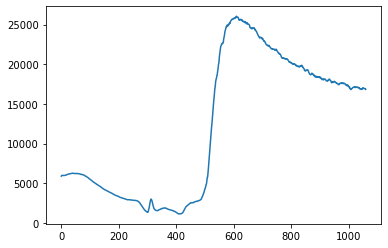

In [108]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window)) # partition line

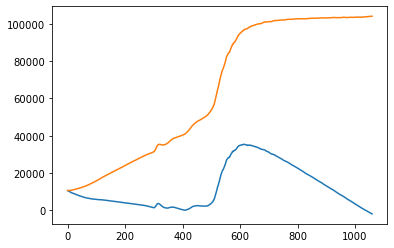

In [119]:
plt.plot(moving_average(p_collapse[2], av_window) - time_diag_collapsed) 
plt.plot(moving_average(p_collapse[2], av_window))

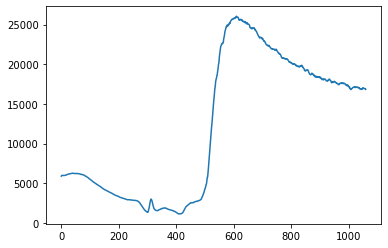

In [113]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[1], av_window))

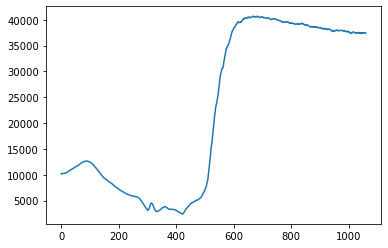

In [116]:
plt.plot(moving_average(p_collapse[2], av_window) - moving_average(p_collapse[0], av_window))

In [ ]:
## SPECS ALL ##
#layers = ['layer_1_Linear', 'laxyer_2_Linear', 'layer_3_Linear'] # 'layer_0_Input'
layers = ['layer_3_Linear']
hier_idxs = np.arange(6)
v = 'v3'
n_components = 2

for layer in layers:
    print(f'\n___________ Layer: {layer}____________')
    method = manifold.MDS(n_components, max_iter=100, n_init=1)
    for hier_idx in hier_idxs:
        if hier_idx == 3:
            break
        num_subsamples = 100
        k = 100
        # hier_idx = 5
        # layer = layers[0]
        mov_avg = 10 
        save_fig = True
        collapse_subsamples = True # whether to average across num_subsamples! currently both computed
        p_array = [5, 50, 95]

        knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
        pkl_name = f'layer={layer}_hier={hier_idx}_with_data.pkl'

        SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
        PLOTDIR = os.path.join(ROOTDIR, 'results', knn_identifier, model_identifier, train_identifier)

        if not os.path.exists(PLOTDIR):
            os.makedirs(PLOTDIR)

        data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

        D = data['D']
        I = data['I']
        I_stand = I/np.max(I)
        I_collap = np.mean(I_stand.reshape(-1, num_subsamples, k),axis=1) # collapse across subsamples
        epochs = data['epochs']
        
#         for i in np.arange(100,1060, 100):
#             print(i)
#             plt.figure()
#             Y = method.fit_transform(I_collap[i:i+100])
#             plt.plot(Y)

        D_k_mean = np.mean(D,axis=1)
        D_k_mean_collapsed = np.mean(D_k_mean.reshape(-1, num_subsamples),axis=1)

        # analyses of fixed points and percentiles
        # compute percentiles
        p = np.percentile(I, p_array, axis=1)
        p_collapse = [np.mean(x.reshape(-1, num_subsamples),axis=1) for x in p]
        time_diag = np.arange(len(D_k_mean))
        time_diag_collapsed = np.arange(len(D_k_mean_collapsed))*100

        norms = np.zeros((k-1, I.shape[0]))
        for i in range(1, k):
            norms[i-1, :] = I[:, 0] - I[:, i] 

        mean_norms = np.mean(norms,axis=0)
        mean_k_norms = np.mean(norms,axis=1)
        # norms_mov_avg = (moving_average(abs(mean_norms), mov_avg))

        norms_collapsed = np.mean(mean_norms.reshape(-1, num_subsamples),axis=1)

        # norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
        norms_mov_avg_collapsed = moving_average(abs(norms_collapsed), mov_avg)
        fixed_point = np.argmin((norms_mov_avg))
        fixed_point_collapsed = np.argmin((norms_mov_avg_collapsed))
        print(f'Hierarchy {hier_idx}: Fixed point collapsed: {fixed_point_collapsed} | Fixed point: {fixed_point}')

Fixed point collapsed, hierarchy 2: 337


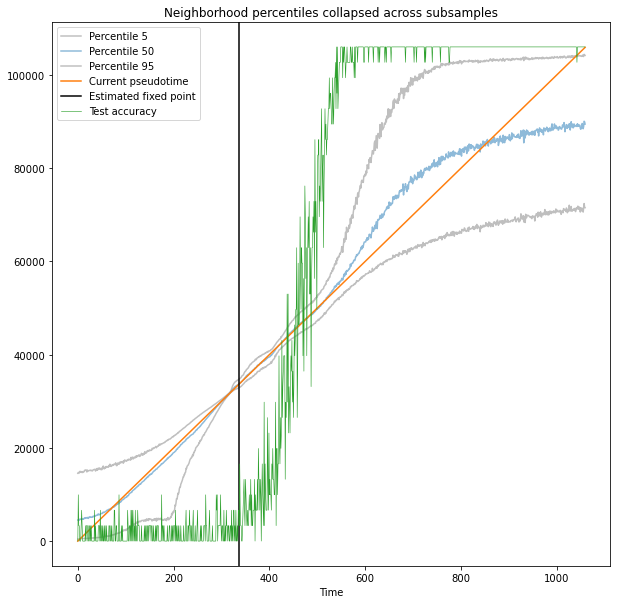

In [3]:
## RUN FOR JUST ONE SPECIFIC SPEC ##
num_subsamples = 100
k = 100
hier_idx = 2
layer = layers[0]
mov_avg = 10 
save_fig = True
collapse_subsamples = True # whether to average across num_subsamples! currently both computed
p_array = [5, 50, 95]

knn_identifier = f'knn_k={k}_subsamples={num_subsamples}'
pkl_name = f'layer={layer}_hier={hier_idx}.pkl'

SAVEDIR = os.path.join(ROOTDIR, 'analyze', knn_identifier, model_identifier, train_identifier)
PLOTDIR = os.path.join(ROOTDIR, 'results', knn_identifier, model_identifier, train_identifier)

if not os.path.exists(PLOTDIR):
    os.makedirs(PLOTDIR)

data = pickle.load(open(os.path.join(SAVEDIR+'/'+pkl_name),'rb'))

D = data['D']
I = data['I']
I_stand = I/np.max(I)
epochs = data['epochs']

D_k_mean = np.mean(D,axis=1)
D_k_mean_collapsed = np.mean(D_k_mean.reshape(-1, num_subsamples),axis=1)

# analyses of fixed points and percentiles
# compute percentiles
p = np.percentile(I, p_array, axis=1)
p_collapse = [np.mean(x.reshape(-1, num_subsamples),axis=1) for x in p]
time_diag = np.arange(len(D_k_mean))
time_diag_collapsed = np.arange(len(D_k_mean_collapsed))*100

norms = np.zeros((k-1, I.shape[0]))
for i in range(1, k):
    norms[i-1, :] = I[:, 0] - I[:, i] 

mean_norms = np.mean(norms,axis=0)
mean_k_norms = np.mean(norms,axis=1)
# norms_mov_avg = (moving_average(abs(mean_norms), mov_avg))

norms_collapsed = np.mean(mean_norms.reshape(-1, num_subsamples),axis=1)

# norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
norms_mov_avg = moving_average(abs(mean_norms), mov_avg)
norms_mov_avg_collapsed = moving_average(abs(norms_collapsed), mov_avg)
fixed_point = np.argmin((norms_mov_avg))
fixed_point_collapsed = np.argmin((norms_mov_avg_collapsed))
print(f'Fixed point collapsed, hierarchy {hier_idx}: {fixed_point_collapsed}')

alpha=0.5
plt.figure(figsize=(10,10))
plt.plot(p_collapse[0], label=f'Percentile {p_array[0]}', alpha=alpha, color='grey')
plt.plot(p_collapse[1], label=f'Percentile {p_array[1]}', alpha=alpha)
plt.plot(p_collapse[2], label=f'Percentile {p_array[2]}', alpha=alpha, color='grey')
plt.xlabel('Time')
plt.title('Neighborhood percentiles collapsed across subsamples')
plt.plot(np.arange(len(p_collapse[0])), time_diag_collapsed, label='Current pseudotime')
plt.axvline(x=fixed_point_collapsed, label='Estimated fixed point', color='black')
plt.plot(np.ravel([np.repeat(x,1) for x in data['test_accs']])*1060, label='Test accuracy', linewidth=0.6)
plt.legend()

In [ ]:
# Investigate why fixed point "goes wrong"

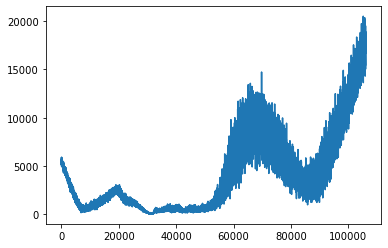

In [6]:
plt.plot(norms_mov_avg)

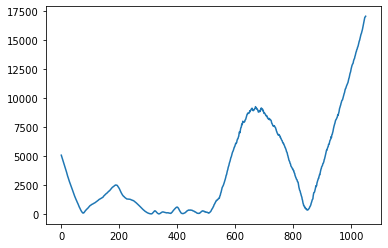

In [7]:
plt.plot(norms_mov_avg_collapsed)

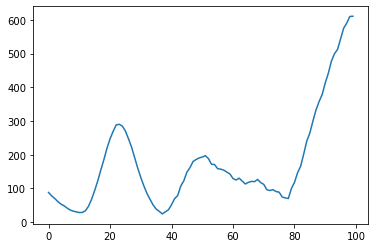

In [9]:
plt.plot(norms_mov_avg_collapsed[300:400])

In [8]:
np.argmin((norms_mov_avg_collapsed))

337

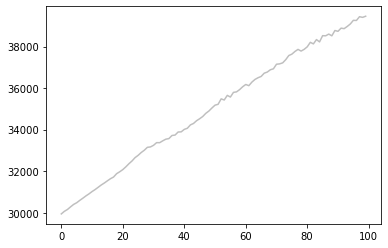

In [11]:
plt.plot(p_collapse[1][300:400], label=f'Percentile {p_array[0]}', alpha=alpha, color='grey')

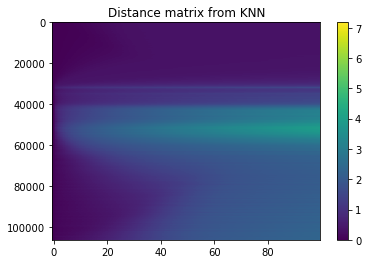

In [12]:
plt.imshow(D,aspect='auto',interpolation=None)
plt.title('Distance matrix from KNN')
plt.colorbar()

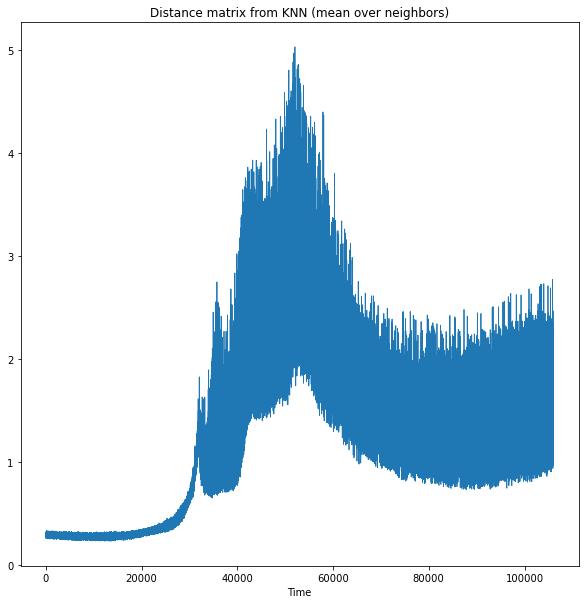

In [13]:
# for exploratory purposes...
plt.figure(figsize=(10,10))
plt.plot(D_k_mean, linewidth=0.8)
plt.title(f'Layer: {layer}; Hierarchy: {hier_idx}: \nDistance matrix from KNN (mean over neighbors)')
plt.xlabel('Time')
# plt.xticks(time_diag[0::100], [str(int(element/100)) for element in time_diag[0::100]])
if save_fig:
    plt.savefig(os.path.join(PLOTDIR, f'dist-matrix_time-avg.pdf'), dpi=240)

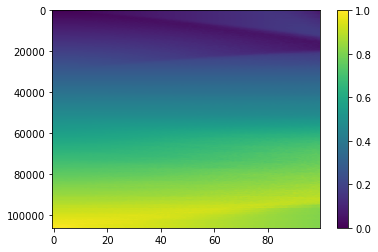

In [32]:
plt.imshow(I_stand,aspect='auto',interpolation=None)
plt.colorbar()

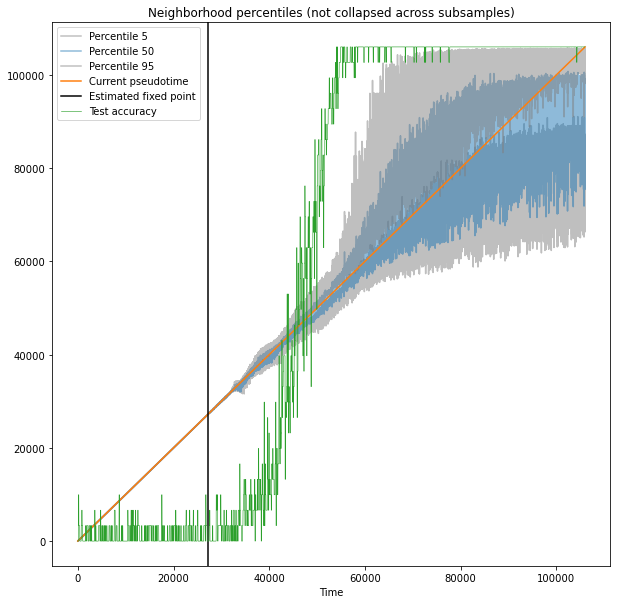

In [18]:
alpha=0.5
plt.figure(figsize=(10,10))
plt.plot(p[0,:], label=f'Percentile {p_array[0]}', alpha=alpha, color='grey')
plt.plot(p[1,:], label=f'Percentile {p_array[1]}', alpha=alpha)
plt.plot(p[2,:], label=f'Percentile {p_array[2]}', alpha=alpha, color='grey')
plt.xlabel('Time')
plt.title('Neighborhood percentiles (not collapsed across subsamples)')
plt.plot(time_diag, label='Current pseudotime')
plt.axvline(x=fixed_point, label='Estimated fixed point', color='black')
plt.plot(np.ravel([np.repeat(x,100) for x in data['test_accs']])*1060, label='Test accuracy', linewidth=0.6)
plt.legend()

Text(0, 0.5, 'Neighborhood distance')

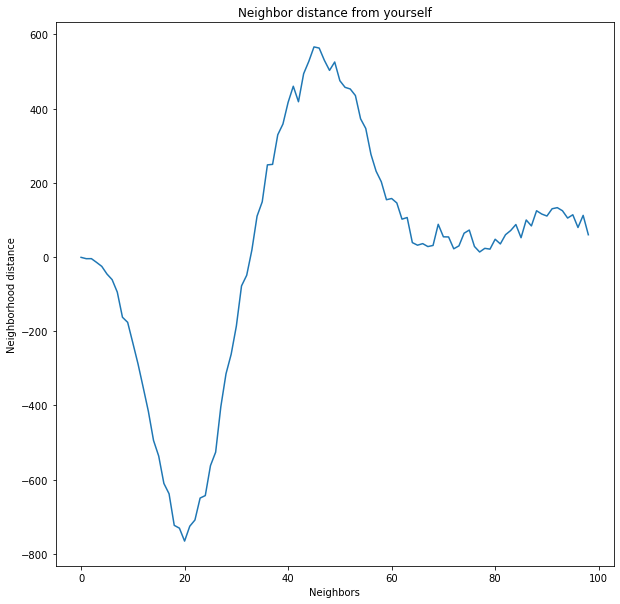